In [1]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [2]:
import time
import itertools

from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, Convolution2D
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#### Let's load the dataset

#### Assumption: The traning data has already been unzipped.

In [3]:
path = "./PINS"

In [4]:
import os
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [5]:
dir_list

['pins_Aaron Paul',
 'pins_Alvaro Morte',
 'pins_Amanda Crew',
 'pins_Amaury Nolasco',
 'pins_Anna Gunn',
 'pins_Benedict Cumberbatch',
 'pins_Betsy Brandt',
 'pins_Brenton Thwaites',
 'pins_Brit Marling',
 'pins_Bryan Cranston',
 'pins_Caity Lotz',
 'pins_Cameron Monaghan',
 'pins_Chance Perdomo',
 'pins_Chris Evans',
 'pins_Chris Pratt',
 'pins_Cobie Smulders',
 'pins_Danielle Panabaker',
 'pins_Dave Franco',
 'pins_Dominic Purcell',
 'pins_Dwayne Johnson',
 'pins_Emilia Clarke',
 'pins_Emily Bett Rickards',
 'pins_Emma Stone',
 'pins_Gwyneth Paltrow',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Jeremy Renner',
 'pins_Jesse Eisenberg',
 'pins_Jim Parsons',
 'pins_Jon Bernthal',
 'pins_Josh Radnor',
 'pins_Kit Harington',
 'pins_Krysten Ritter',
 'pins_Kumail Nanjiani',
 'pins_Maisie Williams',
 'pins_Mark Ruffalo',
 'pins_Martin Starr',
 'pins_Melissa benoit',
 'pins_Mike Colter',
 'pins_Morena Baccarin',
 'pins_Morgan Freeman',
 'pins_Natalie Portman ',
 'pins_Neil Patrick Harr

In [6]:
orig_groups = []
for directory in dir_list:
    images = os.listdir(path+'/'+directory)
    images.sort()
    images = [path+'/'+directory+'/'+x for x in images]
    orig_groups.append(images)

In [7]:
orig_lengths = [len(x) for x in orig_groups]

In [8]:
print(orig_lengths)

[86, 91, 118, 113, 66, 81, 68, 130, 122, 80, 123, 112, 86, 88, 141, 130, 115, 126, 107, 124, 154, 76, 128, 121, 134, 133, 119, 93, 109, 61, 101, 105, 115, 90, 148, 118, 48, 122, 71, 132, 97, 117, 73, 127, 77, 94, 71, 75, 95, 99, 97, 120, 146, 107, 121, 100, 89, 82, 100, 80, 113, 147, 139, 165, 144, 151, 151, 142, 89, 86, 128, 119, 104, 38, 137, 105, 181, 85, 163, 158, 122, 125, 88, 167, 118, 76, 140, 68, 62, 81, 82, 120, 107, 82, 93, 50, 65, 99, 119, 109]


In [9]:
img_h, img_w = 224, 224

#### Now, let's visualise the sample data. We will show one anchor image, one positive and one negative image.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import cv2

def visualize_sample_images():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_groups))
    l = k
    while(k == l):
        l = np.random.randint(len(orig_groups))
    orig_img_names = random.sample(orig_groups[k], 2)
    forg_img_name = random.sample(orig_groups[l], 1)
    orig_img1 = cv2.imread(orig_img_names[0])
    orig_img1 = cv2.cvtColor(orig_img1, cv2.COLOR_BGR2RGB)
    orig_img2 = cv2.imread(orig_img_names[1])
    orig_img2 = cv2.cvtColor(orig_img2, cv2.COLOR_BGR2RGB)
    forg_img = cv2.imread(forg_img_name[0])
    forg_img = cv2.cvtColor(forg_img, cv2.COLOR_BGR2RGB)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1)
    ax2.imshow(orig_img2)
    ax3.imshow(forg_img)

    ax1.set_title('Anchor Image')
    ax1.axis('off')
    ax2.set_title('Positive Image')
    ax2.axis('off')
    ax3.set_title('Negative Image')
    ax3.axis('off')

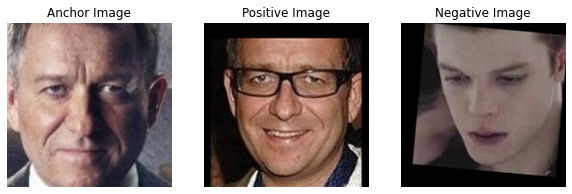

In [11]:
visualize_sample_images()

#### Now let's create pairs of these anchor image, positive and negative images.

In [12]:
def generate_batch(orig_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 276 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 276 = 33120
        # Total no. of data points = 33120 + 33120 = 66240
        for orig in orig_groups:
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(orig)):
                l = i
                while(i == l):
                    l = np.random.randint(len(orig_groups))
                    forg_pairs.extend(list(itertools.product(orig_groups[l], random.sample(orig, 1))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

#### Let's create a model to generate embedding. we will use pretrained weights provided in task (vgg_face_weights).

In [13]:
input_shape=(img_h, img_w, 3)

In [14]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [16]:
model.load_weights('Part 3 - vgg_face_weights.h5')

In [17]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [18]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [19]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_w, img_h))
    img = np.expand_dims(img, axis=0)
    return img

#### Let's create a utility function to verify if it'same face or not. 

In [20]:
# epsilon = 150 #euclidean distance
epsilon = 0.40 #cosine similarity

def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(img1)[0,:]
    img2_representation = vgg_face_descriptor.predict(img2)[0,:]
    
    cosine_similarity = findCosineDistance(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
     
    print("Cosine Similarity: " + str(cosine_similarity))
    print("Euclidean Distance: " + str(euclidean_distance))
    if(cosine_similarity < epsilon):
        print("prediction... they are same person")
    else:
        print("prediction... they are not same person!")

In [23]:
from os import walk

test_gen = generate_batch(orig_groups, 1)

def predict_score(same=False):
    '''Predict distance score and classify test images as Genuine or Forged'''
    rand_dir1 = path+'/' + random.choice(dir_list)
    rand_dir2 = path+'/' + random.choice(dir_list)
    img1 = preprocess_image(rand_dir1 +'/' +random.choice(next(walk(rand_dir1))[2]))
    img2 = preprocess_image(rand_dir2 +'/' +random.choice(next(walk(rand_dir2))[2]))
    if same:
        img2 = preprocess_image(rand_dir1 +'/' +random.choice(next(walk(rand_dir1))[2]))
    verifyFace(img1, img2)
    img1 = cv2.cvtColor(np.squeeze(img1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(np.squeeze(img2), cv2.COLOR_BGR2RGB)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(img1)
    ax2.imshow(img2)
    ax1.set_title(rand_dir1)
    ax2.set_title(rand_dir2)
    if same:
        ax2.set_title(rand_dir1)
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    print('--------------------------------------------------------------------------')

Cosine Similarity: 0.6334733366966248
Euclidean Distance: 195.70787
prediction... they are not same person!


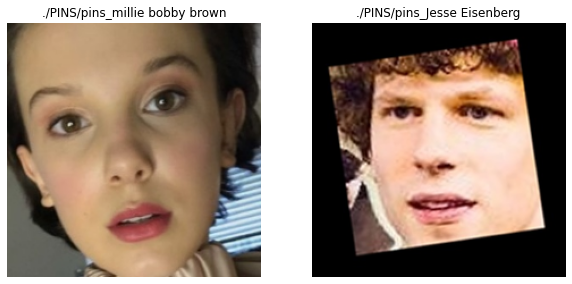

--------------------------------------------------------------------------
Cosine Similarity: 0.23535925149917603
Euclidean Distance: 97.94043
prediction... they are same person


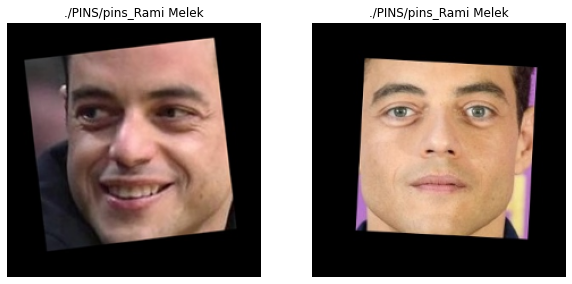

--------------------------------------------------------------------------
Cosine Similarity: 0.8949379846453667
Euclidean Distance: 299.49908
prediction... they are not same person!


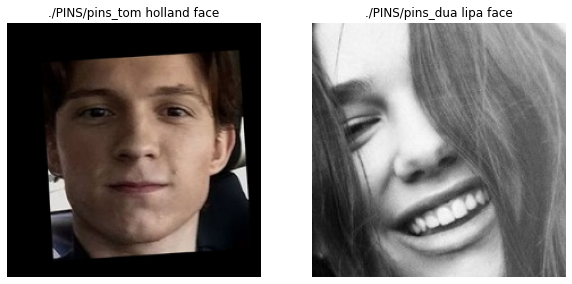

--------------------------------------------------------------------------
Cosine Similarity: 0.2016148567199707
Euclidean Distance: 108.47972
prediction... they are same person


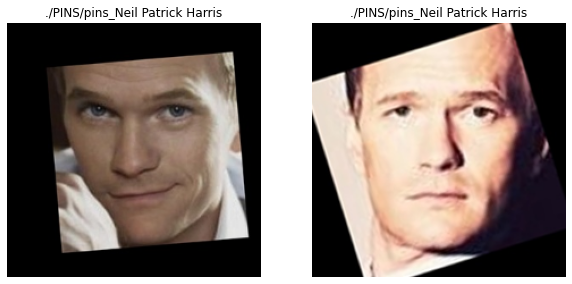

--------------------------------------------------------------------------
Cosine Similarity: 0.6784937083721161
Euclidean Distance: 193.36658
prediction... they are not same person!


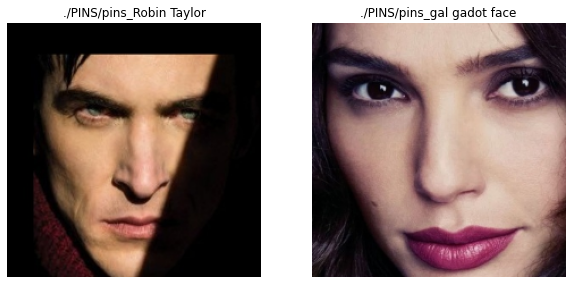

--------------------------------------------------------------------------
Cosine Similarity: 0.6799823343753815
Euclidean Distance: 184.24951
prediction... they are not same person!


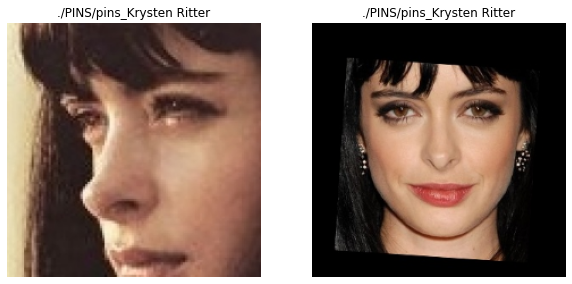

--------------------------------------------------------------------------
Cosine Similarity: 0.4863726496696472
Euclidean Distance: 145.13014
prediction... they are not same person!


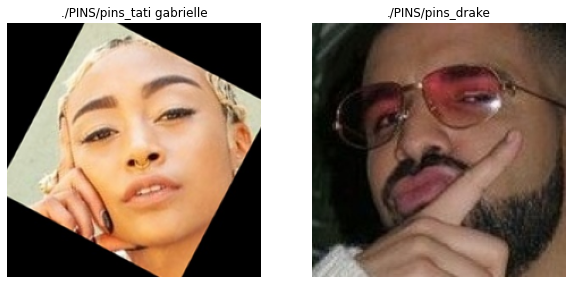

--------------------------------------------------------------------------
Cosine Similarity: 0.2994725704193115
Euclidean Distance: 104.9977
prediction... they are same person


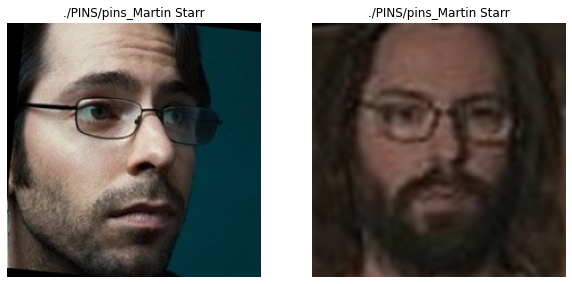

--------------------------------------------------------------------------
Cosine Similarity: 0.5525065362453461
Euclidean Distance: 199.56972
prediction... they are not same person!


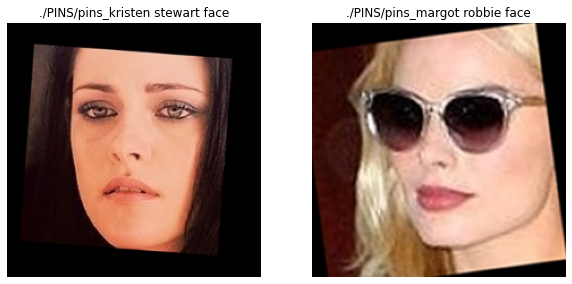

--------------------------------------------------------------------------
Cosine Similarity: 0.20244616270065308
Euclidean Distance: 126.00123
prediction... they are same person


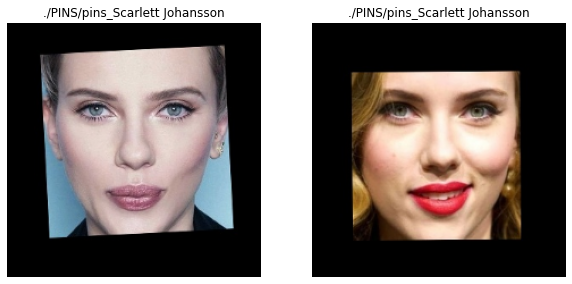

--------------------------------------------------------------------------
Cosine Similarity: 0.5435537695884705
Euclidean Distance: 175.13573
prediction... they are not same person!


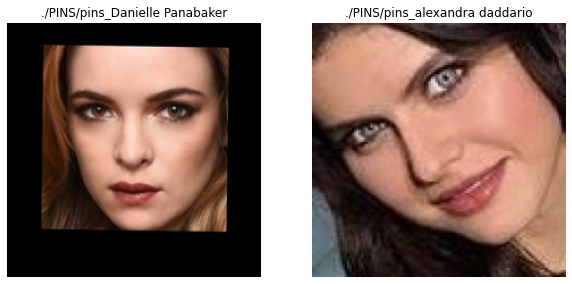

--------------------------------------------------------------------------
Cosine Similarity: 0.1933642029762268
Euclidean Distance: 93.89237
prediction... they are same person


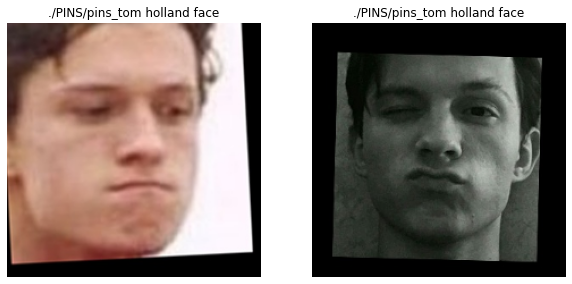

--------------------------------------------------------------------------
Cosine Similarity: 0.6495120227336884
Euclidean Distance: 224.60394
prediction... they are not same person!


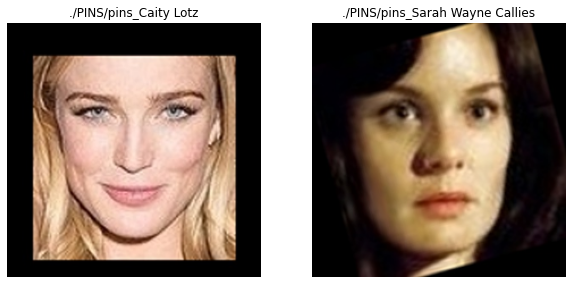

--------------------------------------------------------------------------
Cosine Similarity: 0.43463242053985596
Euclidean Distance: 128.59859
prediction... they are not same person!


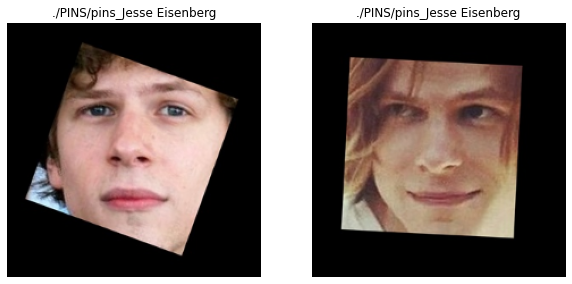

--------------------------------------------------------------------------
Cosine Similarity: 0.5732413828372955
Euclidean Distance: 118.71487
prediction... they are not same person!


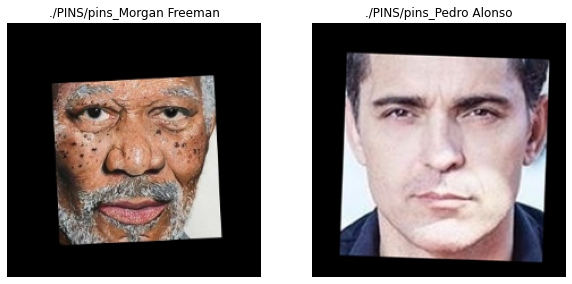

--------------------------------------------------------------------------
Cosine Similarity: 0.32611024379730225
Euclidean Distance: 169.40508
prediction... they are same person


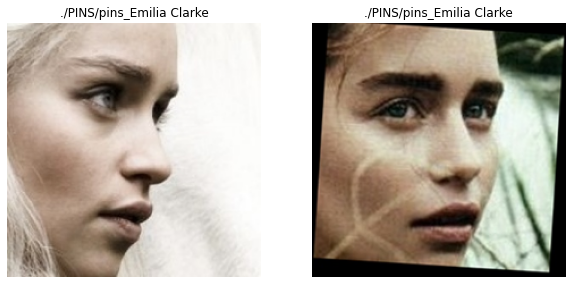

--------------------------------------------------------------------------
Cosine Similarity: 0.7382830381393433
Euclidean Distance: 183.59567
prediction... they are not same person!


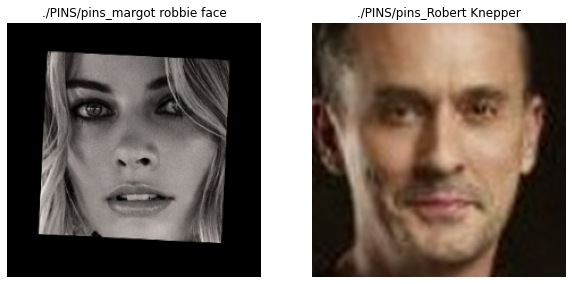

--------------------------------------------------------------------------
Cosine Similarity: 0.48969054222106934
Euclidean Distance: 121.82054
prediction... they are not same person!


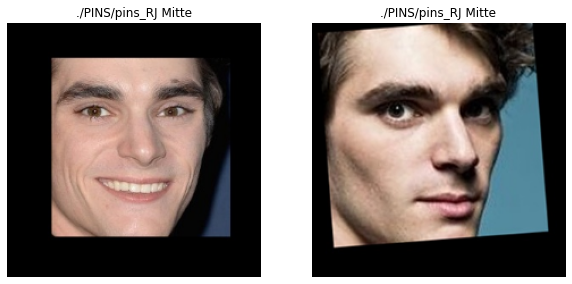

--------------------------------------------------------------------------
Cosine Similarity: 0.4101090431213379
Euclidean Distance: 155.72961
prediction... they are not same person!


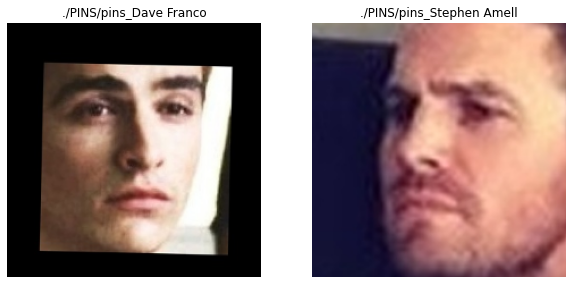

--------------------------------------------------------------------------
Cosine Similarity: 0.28626686334609985
Euclidean Distance: 71.209526
prediction... they are same person


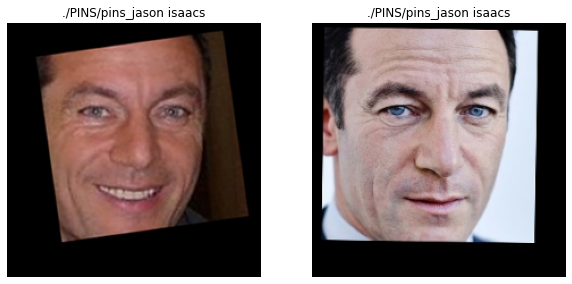

--------------------------------------------------------------------------


In [24]:
for i in range(10):
    predict_score()
    predict_score(True)

#### Improvement

##### We could have trained an SVM using pairs that we created (for distance), to classify instead of using hardcoded epsilon.